**<h3><center>EN2550 Assignment 2</center></h3>**
*Name - Ekanayake E.M.S.S.N.*
<br>
*Index no - 190164M*
<br>
GitHub - https://github.com/SevinduEk/EN2550_Assignment_02
<br>
<hr>

**01**

RANSAC algorithms use randomly selected samples for fitting. In this code, we select randomly three points and estmate the circle. Then a distance threshold value is set to determine inliers and outliers. The fitting circle is selected by considering the number of inliers.<br>
<i>findCircle</i> function is used to determine the circles generated by three sample points<br>
<i>ransac_</i> function is used to iterate over samples and <i>shortest_distance</i> is used to filter out outliers. 

8.269718737093372
10.157177470293764


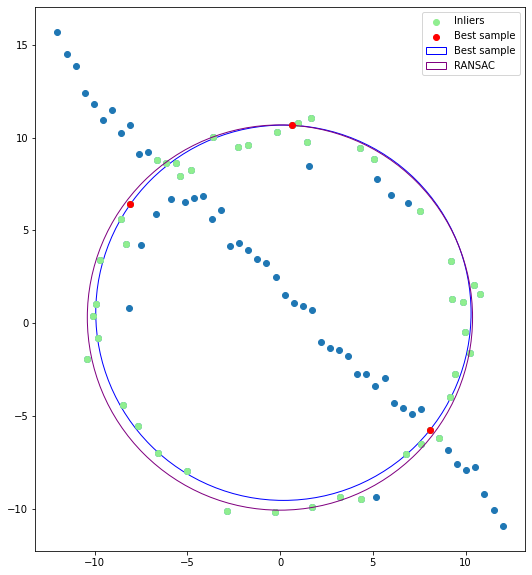

In [73]:
def shortest_distance(p,cen_x,cen_y,radius):
    dist = np.array(abs(((p[:,0]-cen_x)**2 + (p[:,1]-cen_y)**2)**0.5-radius))
    return dist

def findCircle(pt1, pt2, pt3):
    temp = pt2[0]**2 + pt2[1]**2
    bc = (pt1[0]**2 + pt1[1]**2 - temp)/2
    cd = (temp - pt3[0]**2 - pt3[1]**2)/2
    det = (pt1[0] - pt2[0]) * (pt2[1] - pt3[1]) - (pt2[0] - pt3[0]) * (pt1[1] - pt2[1])

    if abs(det) < 1.0e-10:
        return None
    cx = (bc*(pt2[1] - pt3[1]) - cd*(pt1[1] - pt2[1]))/ det
    cy = ((pt1[0] - pt2[0]) * cd - (pt2[0] - pt3[0])*bc)/ det

    r = ((cx - pt1[0])**2 + (cy - pt1[1])**2)**0.5

    return cx, cy, r

def ransac_(data,iteration,thresh,no_of_inliers):
    maximum = 0
    output = np.array([])

    for i in range(iteration):
        randomPoints=np.random.choice(data.size//2, size=3, replace=False)
        cen_x,cen_y,radius=findCircle(data[randomPoints[0]],data[randomPoints[1]],data[randomPoints[2]])
        PO=shortest_distance(data,cen_x,cen_y,radius)

        if radius>max(data[:,1])*1.5:
            continue
        inliers_ = data[PO<thresh]

        if len(inliers_)>no_of_inliers:
               
            shrt_d=shortest_distance(inliers_,cen_x,cen_y,radius)
            mean = sum(shrt_d/shrt_d.size)
            if maximum < len(inliers_):
                best=mean
                output=randomPoints
                inl_=inliers_
            elif maximum == len(inliers_) and best>mean:
                best=mean
                output=randomPoints
                inl_=inliers_
    print(radius)
    return output,inl_

**02**

Here we try to superimpose a flag on an architectural image. First we give the four points which are used as the corners for the flag (<i>Points_</i> function). Then we take that plane in the source image (building) and calculate homography using built-in function in opencv. <br>
Then we warp the flag using the calculated homography to fit on the plane mentioned above using <i>cv2.warpPerspective</i> function. To blend the warped image and the background,  <i>cv2.addWeighted</i> function is used which is a linear blending function. <br>
Background images and the corner points are selected the way parallel lines in the flags do not remain parallel in the final outcome. 

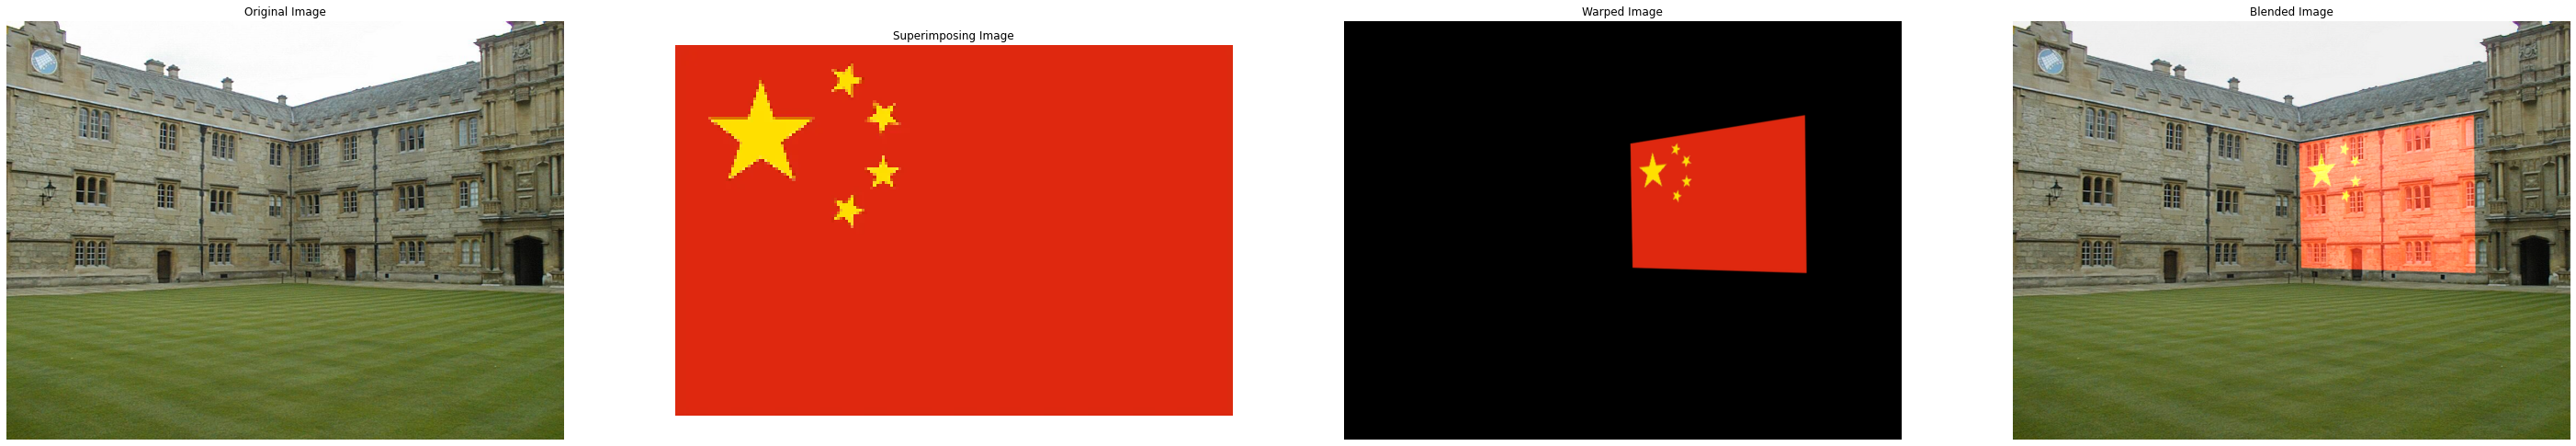

In [9]:
count = 0
points = []
width = 0
height = 0

def Points_(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None

def shape_find(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2

    return width, height

pts_src = np.array([[0,0], [superimpose_img.shape[1],0], [0, superimpose_img.shape[0]], [superimpose_img.shape[1],superimpose_img.shape[0]]]) 
pts_dst = np.array(points)
shape0, shape1 = shape_find(points)

h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
im_out = cv.warpPerspective(superimpose_img, h, (src_img.shape[1], src_img.shape[0]))
blend_image = cv.addWeighted(src_img, 0.95, im_out, 0.8, 0.0)

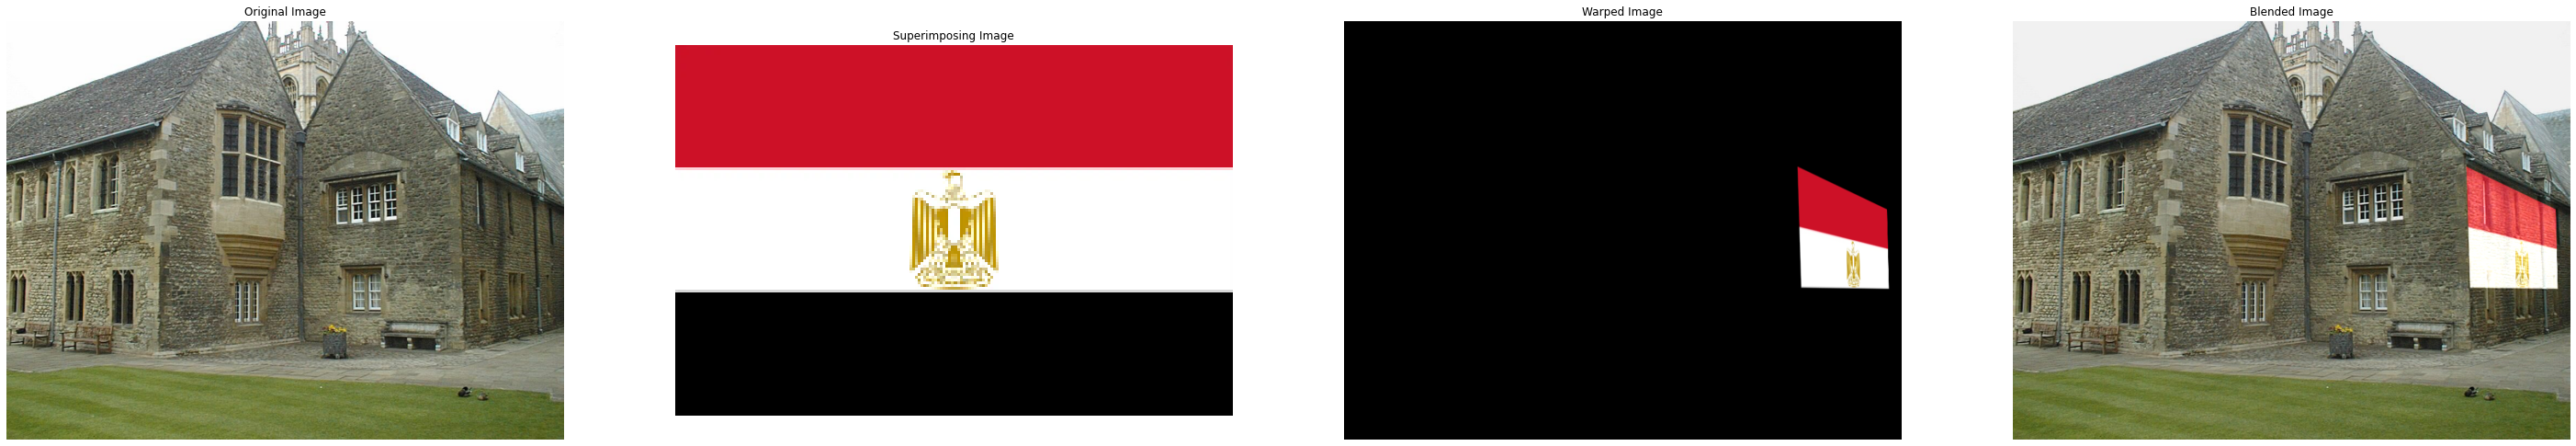

**03**

**(a)**

<i>SIFT</i> function defined below is used to match sift features between two images using the built-in functions.

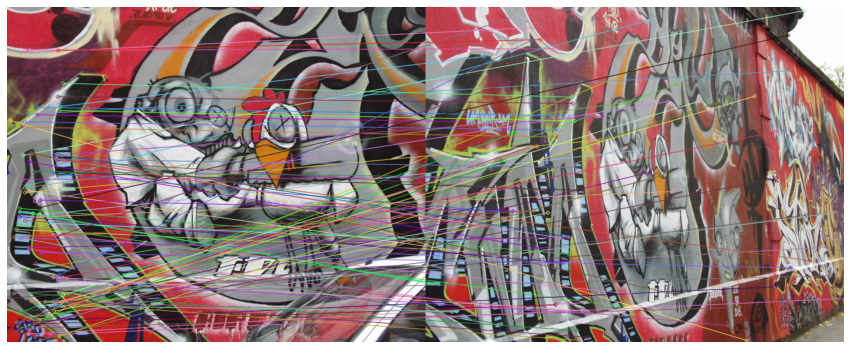

In [36]:
def SIFT(img1,img2):
    sift = cv.SIFT_create(nfeatures=0,nOctaveLayers=3,contrastThreshold=0.04,edgeThreshold=10,sigma=1.6) 
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)   
    matches = bf.match(descriptors_1,descriptors_2)
    sortmatches = sorted(matches, key = lambda x:x.distance)
    img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:100], img2, flags=2)
    return matches,[keypoints_1,keypoints_2], img3
    
kp1,kp2,img_ = SIFT(img1,img5)

**(b)**

The method we use here to calculate the homography of image 1 to 5 is, finding the homography for image 1 to 2, then 2 to 3, then 3 to 4 and then 4 to 5 and using them to calculate the final result as shown below. (Because 3x3 matrix transformations are closed under composition)
$$T_{51} = T_{54}T_{43}T_{32}T_{21}$$
<i>Mathematical Approach</i>:
Find the set of matching features between images(mentioned above)
Find the eigenvector <i>h</i> with smallest eigenvalue of matrix A<sup>T</sup>A
<br>
<i>RANSAC Approach</i>:
In SIFT, we first generate keypoints and the feature vector for each keypoint. Then, we apply RANSAC. We randomly pick four good matches, compute a homography from these four, and test how good this homography is by checking number of inliers and outliers. Then we repeat this number of times and keep the homography with the smallest number of outliers.
<br>Code for calculating homography within RANSAC is shown below.

In [63]:
def Homography_calc(correspondnce_list):
    Lst = []
    for corr in correspondnce_list:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        Lst.append(a1)
        Lst.append(a2)
    matrixA = np.matrix(Lst)
    u, s, v = np.linalg.svd(matrixA) 
    h = np.reshape(v[8], (3, 3)) 
    h = (1/h.item(8)) * h 
    return h

def geometricD(correspondence, h):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep1 = np.dot(h, p1)
    estimatep2 = (1/estimatep1.item(2))*estimatep1
    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def RANSAC_func(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        h = Homography_calc(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricD(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        
        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

def corr_list(matches,key):
    correspondenceList1 = []
    kp1 = [key[0],key[1]]
    for match in matches:
        (x1, y1) = kp1[0][match.queryIdx].pt
        (x2, y2) = kp1[1][match.trainIdx].pt
        correspondenceList1.append([x1, y1, x2, y2])
    return correspondenceList1

match1,kyp1,testim1=SIFT (img1,img2)
correspondenceList1=corr_list(match1,kyp1)
corrs1 = np.matrix(correspondenceList1)
finalH1, inliers1 = RANSAC_func(corrs1, 0.6)
...
H = finalH4 @ finalH3 @ finalH2 @ finalH1

[[ 6.35655187e-01  7.16470117e-02  2.23222179e+02]
 [ 2.31926284e-01  1.20329844e+00 -3.22409354e+01]
 [ 4.96287383e-04  8.36258156e-06  1.00814325e+00]]


Sum of square difference is calculated for comparing the given homography and calculated homography

In [64]:
SSD = np.sum(np.sum(np.multiply((given_homo-H),(given_homo-H))))

45.49355524758041


**(c)**

Image 1 is warped using the homography, and stitched on image 5 

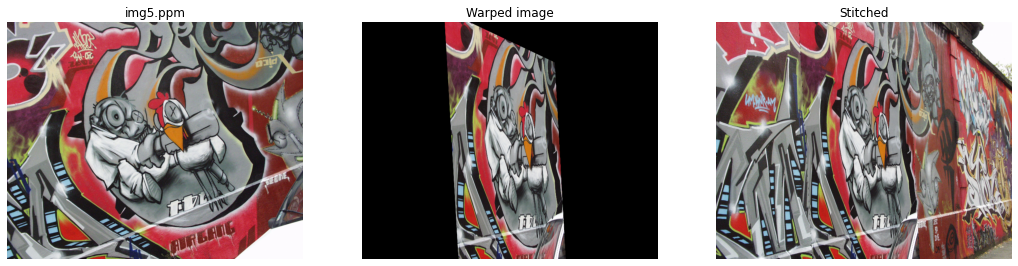

In [76]:
img_p = cv.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)
img5_thresholded = np.multiply(threshold, img5)
img_blended = cv.addWeighted(img5_thresholded, 1, img_p, 1, 0)